# Calibration Data

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
calib = pd.read_csv('calib.csv', header=0, names=['Interval', 'Channel'])

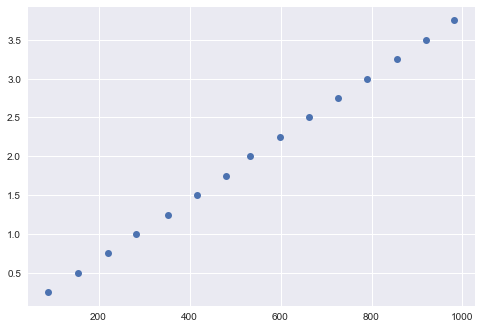

In [30]:
plt.style.use('seaborn')
plt.plot(calib['Channel'], calib['Interval'], 'o')

In [31]:
X = calib['Channel']
Y = calib['Interval']
fit = linregress(X, Y)
f = lambda c: fit.slope*c + fit.intercept

In [32]:
calib['Time'] = f(calib.index)

# Applying to data

In [33]:
test_data = pd.read_csv('Exp3_Tue_4day_RUN2.csv', header=0)

In [34]:
test_data['Time'] = f(test_data['Channel'])

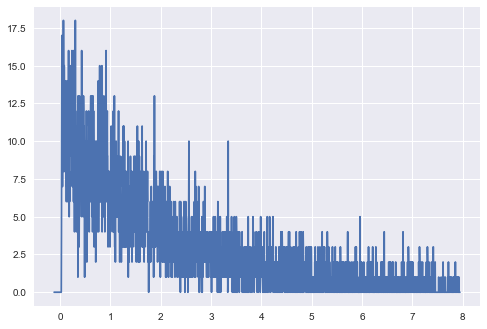

In [35]:
plt.plot(test_data['Time'], test_data['Counts'])

In [36]:
def func(x, a, c):
    return a*np.exp(-c*x)
    

data_fit = curve_fit(func, test_data['Time'], test_data['Counts'])

In [37]:
a, c = data_fit[0]

time constant is 2.660884929516452


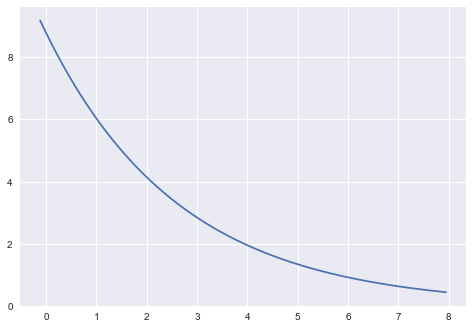

In [38]:
x = test_data['Time']
plt.plot(x, func(x, a, c))
print('time constant is {}'.format(1 / c))

In [41]:
actual = 2.22
error = np.abs(actual - 1/c) / actual * 100
print(error)

19.8596815098
